# Setting up

Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/Lab5 NLP" /content

In [3]:
%cd "/content/Lab5 NLP"

/content/drive/.shortcut-targets-by-id/1XFdYuE8rHrSu7dNPzRg9fYr7ijFVPVRB/Lab5 NLP


Imports 

In [4]:
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 15.2 MB/s 
     |████████████████████████████████| 965 kB 66.6 MB/s 


In [5]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from string import ascii_lowercase, digits, punctuation
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

Check available gpu

In [6]:
gpu_available = tf.config.list_physical_devices('CPU')
if len(gpu_available) == 0:
  device = tf.device('/device:CPU:0')
else:
  device = tf.device('/device:GPU:0')

# Data

### Train and test data

In [7]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [8]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


In [9]:
labels_train = data_train.iloc[:, 0].values
reviews_train = data_train.iloc[:, 1].values

In [10]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

### Typos, teencode/ slang, stopwords

In [ ]:
# stopwords = pd.read_csv("vietnamese_stopwords.txt", sep='\t')
# stopwords_dash = stopwords.iloc[:,0].values
# stopwords_dash

In [11]:
typo = pd.read_csv("typo.txt", sep = '\t')
typo_words = typo.iloc[:,0].values
replace_typos = typo.iloc[:,1].values

In [12]:
teencode = pd.read_csv("teencode.txt", sep = '\t')
teencode_words = teencode.iloc[:,0].values
replace_words = teencode.iloc[:,1].values

In [ ]:
teencode_words[:10]

array(['ctrai', 'éo', 'dag', 'zay', 'bt', 'khôg', 'bme', 'ngol', 'cta',
       'mih'], dtype=object)

In [ ]:
replace_words[:10]

array(['con_trai', 'không', 'đang', 'vậy', 'bình_thường', 'không',
       'bố_mẹ', 'ngon', 'chúng_ta', 'mình'], dtype=object)

Create dictionary for teencode and typo

In [13]:
typo_dict = {}
for i in range(len(typo_words)):
  typo_dict[typo_words[i]] = replace_typos[i]

print(typo_dict)

{'adnroid': 'android', 'adroid': 'android', 'andoid': 'android', 'andorid': 'android', 'androi': 'android', 'anroid': 'android', 'droid': 'android', 'aiphon': 'iphone', 'aiphone': 'iphone', 'aple': 'apple', 'appel': 'apple', 'asuck': 'asus', 'bbry': 'blackberry', 'blackckberry': 'blackberry', 'blackbery': 'blackberry', 'btuetooth': 'bluetooth', 'bluethooth': 'bluetooth', 'bluetouth': 'bluetooth', 'blutoot': 'bluetooth', 'blutooth': 'bluetooth', 'chịná': 'china', 'chíp': 'chip', 'contac': 'contact', 'conect': 'connect', 'dowload': 'download', 'dùngvaà': 'dùng và', 'đagn': 'đang', 'điiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii': 'đi', 'đọv': 'đọc', 'đứnghoài': 'đứng hoài', 'expnsive': 'expensive', 'fim': 'film', 'formart': 'format', 'galaaxy': 'galaxy', 'gảmin': 'gaming', 'giiwf': 'giờ', 'glaxy': 'galaxy', 'huwaei': 'huawei    ', 'huwei': 'huawei', 'iclound': 'icloud', 'ifone': 'iphone', 'ihone': 'iphone', 'ipnone': 'iphone', 'kkkkkkkkkkkkk': 'kk', 'kkkkkkk': 'kk', 'kkk': 'kk', 'kkhác': 'khác', 'mar

In [14]:
teencode_dict = {}
for i in range(len(teencode_words)):
  teencode_dict[teencode_words[i]] = replace_words[i]

print(teencode_dict)

{'ctrai': 'con_trai', 'éo': 'không', 'dag': 'đang', 'zay': 'vậy', 'bt': 'bình_thường', 'khôg': 'không', 'bme': 'bố_mẹ', 'ngol': 'ngon', 'cta': 'chúng_ta', 'mih': 'mình', 'mqh': 'mối_quan_hệ', 'cgai': 'con_gái', 'nhữg': 'những', 'mng': 'mọi_người', 'rùi': 'rồi', 'svtn': 'sinh_viên_tình_nguyện', 'r': 'rồi', 'mún': 'muốn', 'ụaj': 'gì', 'qtam': 'quan_tâm', 'thươg': 'thương', 'qtâm': 'quan_tâm', 'chug': 'chung', 'trườg': 'trường', 'thoy': 'thôi', 'đki': 'đăng_ký', 'atsm': 'ảo_tưởng_sức_mạnh', 'kỉu': 'kiểu', 'gj': 'gì', 'cổg': 'cổng', 'pên': 'bên', 'tráj': 'trái', 'ạk': 'ạ', 'cv': 'công_việc', 'vch': 'vãi_chưởng', 'cùg': 'cùng', 'pn': 'bạn', 'pjt': 'biết', 'thjk': 'thích', 'keke': 'ce_ce', 'ktra': 'kiểm_tra', 'nek': 'nè', 'cgái': 'con_gái', 'nthe': 'như_thế', 'chúg': 'chúng', 'kái': 'cái', 'tìh': 'tình', 'phòg': 'phòng', 'lòg': 'lòng', 'từg': 'từng', 'rằg': 'rằng', 'sốg': 'sống', 'thuj': 'thôi', 'thuơng': 'thương', 'càg': 'càng', 'đky': 'đăng_ký', 'bằg': 'bằng', 'sviên': 'sinh_viên', 'ák': '

## Preprocess data

In [15]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 150 # max number of words in a comment to use

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import regex as re
import unicodedata

In [17]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [18]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [19]:
def remove_apostrophe(text):
    aspostrophe_pattern = re.compile(r'\'s')
    return aspostrophe_pattern.sub(r'', text)

In [ ]:
# def remove_price(text):
#   price_pattern = re.compile(r'\d+k|\d+tr\d*|\d+cu|d+ củ|d+ triệu|d+ trăm|d+ trăm ngàn|d+ trieu')
#   return price_pattern.sub(r'', text)

visualize train set

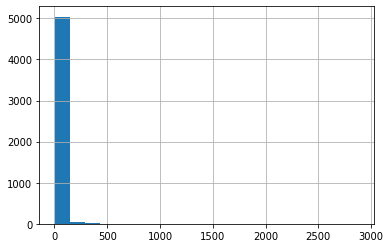

avarage length 29.353921568627452
maximum length 2885


In [ ]:
seq_len = [len(i.split()) for i in reviews_train]
pd.Series(seq_len).hist(bins = 20)
plt.show()
total_avg = sum( map(lambda x: len(x.split()), reviews_train) ) / len(reviews_train)
max_len = max(map(lambda x: len(x.split()), reviews_train))
print('avarage length', total_avg)
print('maximum length', max_len)

visualize test set

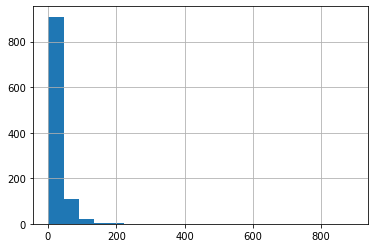

avarage length 26.482857142857142
maximum length 892


In [20]:
seq_len = [len(i.split()) for i in reviews_test]
pd.Series(seq_len).hist(bins = 20)
plt.show()
total_avg = sum( map(lambda x: len(x.split()), reviews_test) ) / len(reviews_test)
max_len = max(map(lambda x: len(x.split()), reviews_test))
print('avarage length', total_avg)
print('maximum length', max_len)

### Define preprocess function

In [21]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)

def preprocess(reviews, labels, train = False):
  encoded_labels = []

  for label in labels:
      if label == -1:
          encoded_labels.append([1,0,0])
      elif label == 0:
          encoded_labels.append([0,1,0])
      else:
          encoded_labels.append([0,0,1])

  encoded_labels = np.array(encoded_labels) 

  reviews_processed = []
  unlabeled_processed = [] 
  for review in reviews:
    review = unicodedata.normalize('NFC', review)
    review = remove_emoji(review)
    review = remove_urls(review)
    review = remove_apostrophe(review)
    regex_review = re.sub(r"[!\"#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}]", ' ', review)
    review_cool_one = ''.join([char for char in regex_review if (char not in digits and char not in punctuation)])
    reviews_processed.append(review_cool_one)
  #Use PyVi for Vietnamese word tokenizer
  word_reviews = []
  all_words = []

  for review in reviews_processed:
    review = list(map(teencode_dict.get, review.lower().split(), review.lower().split()))
    review = list(map(typo_dict.get, review, review))
    review = ' '.join([word for word in review])
    review = ViTokenizer.tokenize(review)
    # review = list(filter(lambda x: x not in r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]' 
    #                      and x not in list(ascii_lowercase), review))
    review = review.split()
    word_reviews.append(review)

  if train:
    tokenizer.fit_on_texts(word_reviews)
    print('after preprocessing')
    seq_len = [len(i) for i in word_reviews]
    pd.Series(seq_len).hist(bins = 20)
    plt.show()
    total_avg = sum( map(len, word_reviews) ) / len(word_reviews)
    max_len = max(map(len, word_reviews))
    print('average length', total_avg)
    print('maximum length', max_len)

  sequences_train = tokenizer.texts_to_sequences(word_reviews) #[[7, 44, 82, 1, 1, 28, 55, 72], [...], ...]

  data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
  labels = encoded_labels

  print('Shape of X train and X validation tensor:',data.shape)
  print('Shape of label train and validation tensor:', labels.shape)

  return data, labels

### Test


In [ ]:
# reviews_processed = []
# unlabeled_processed = [] 
# for review in reviews_train[-30:-20]:
#   print(review)
#   # chuan hoa chuoi unicode
#   review = unicodedata.normalize('NFC', review)
#   # loai bo emoji
#   review = remove_emoji(review)
#   # loai bo url
#   review = remove_urls(review)
#   review = remove_apostrophe(review)
#   # review = remove_price(review)
#   # loai bo cac ki tu dac biet
#   regex_review = re.sub(r"[!\"#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}]", ' ', review)
#   review_cool_one = ''.join([char for char in regex_review if (char not in digits and char not in punctuation)])
#   review_cool_one = review_cool_one.lower()
#   reviews_processed.append(review_cool_one)
#   print(review_cool_one)
# #Use PyVi for Vietnamese word tokenizer
# word_reviews = []
# all_words = []

# # subs = {v:k for k, v in teencode_dict.items()}

# for review in reviews_processed:
#   review = review.split()
#   review = list(map(typo_dict.get, review, review))
#   print("remove typo", review)
#   review = list(map(teencode_dict.get, review, review))
#   print("remove teencode", review)
#   review = ' '.join([word for word in review])
#   print(review)
#   review = ViTokenizer.tokenize(review)
#   # review = list(filter(lambda x: x not in r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]' 
#   #                      and x not in list(ascii_lowercase), review))
#   review = review.split()
#   word_reviews.append(review)
#   print(review)

### preprocess data

after preprocessing


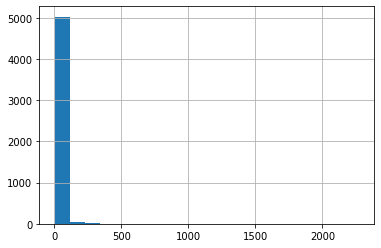

average length 25.253333333333334
maximum length 2273
Shape of X train and X validation tensor: (5100, 150)
Shape of label train and validation tensor: (5100, 3)


In [22]:
data, labels = preprocess(reviews_train, labels_train, train = True)

In [ ]:
print(preprocess(['sao mãi mà zeml vẫn chưa có bản cập nhật lên androi   vậy ad   trog khi zen laser thì có từ lâu rồi'],[0]))

Shape of X train and X validation tensor: (1, 150)
Shape of label train and validation tensor: (1, 3)
(array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   91,  540,    9, 7708,
         

In [23]:
word_index = tokenizer.word_index #['giới_thiệu': 842,'điện_tử': 843,'phai': 844,'nhược_điểm': 845,...]

In [24]:
len(word_index)

7717

In [ ]:
word_index.get('androi')

In [ ]:
dictionary = pd.DataFrame(word_index.items())

In [ ]:
dictionary.to_csv('dict.csv')

#Model and train section

## Embedding layer based on Vietnamese CBOW

In [25]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/Lab5 NLP/vi-model-CBOW.bin', binary=True)



vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

## CNN (Kim2014, double filter)

In [ ]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, BatchNormalization, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, concatenate
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
# reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

conv_0b = Conv1D(num_filters, filter_sizes[0],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)


conv_1 = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

conv_1b = Conv1D(num_filters, filter_sizes[1],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)


conv_2 = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)

conv_2b = Conv1D(num_filters, filter_sizes[2],activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)


# uncomment these lines to change into double filter
maxpool_0 = AveragePooling1D(conv_0.shape[1], strides=1)(conv_0)
maxpool_0b = AveragePooling1D(conv_0b.shape[1], strides=1)(conv_0b)
maxpool_1 = AveragePooling1D(conv_1.shape[1], strides=1)(conv_1)
maxpool_1b = AveragePooling1D(conv_1b.shape[1], strides=1)(conv_1b)
maxpool_2 = AveragePooling1D(conv_2.shape[1], strides=1)(conv_2)
maxpool_2b = AveragePooling1D(conv_2b.shape[1], strides=1)(conv_2b)

merged_tensor = concatenate([maxpool_0
                             , maxpool_0b
                             , maxpool_1
                             , maxpool_1b
                             , maxpool_2
                             , maxpool_2b
                             ], axis=1)

flatten = Flatten()(merged_tensor)
reshape = Reshape((6*num_filters,))(flatten)

dropout = Dropout(drop)(reshape)
dense_0 = Dense(256, activation = 'relu')(dropout)
output = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dense_0)


# this creates a model that includes
model = Model(inputs, output)


adam = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 400)     3087200     ['input_8[0][0]']                
                                                                                                  
 conv1d_33 (Conv1D)             (None, 148, 100)     120100      ['embedding[7][0]']              
                                                                                                  
 conv1d_34 (Conv1D)             (None, 148, 100)     120100      ['embedding[7][0]']              
                                                                                           

## LSTM (single or multiple LSTM layers, BiLSTM)

###LSTM

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
spatial_dropout = SpatialDropout1D(0.2)(embedding)

################# SINGLE LSTM ####################
lstm_0 = LSTM(64)(spatial_dropout)

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
# lstm_2 = LSTM(512, dropout = drop, return_sequences=True)(reshape)
# lstm_1 = LSTM(256, dropout = drop, return_sequences=True)(lstm_2)
# lstm_0 = LSTM(128)(lstm_1)

# dropout = Dropout(drop)(concat)
dropout = Dropout(0.2)(lstm_0)
dense_0 = Dense(64, activation = 'relu')(dropout)
# dense_1 = Dense(16, activation = 'relu')(dense_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dense_0)

# this creates a model that includes
model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 150)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 150, 400)          3087200   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 150, 400)         0         
 lDropout1D)                                                     
                                                                 
 lstm_50 (LSTM)              (None, 64)                119040    
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 64)                4160      
                                                          

###Bidirectional LSTM

In [ ]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]

sequence_length = data.shape[1]
inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

biLSTM_0 = Bidirectional(LSTM(512, dropout = 0.2, return_sequences=True), merge_mode='concat')(embedding)

biLSTM_1 = Bidirectional(LSTM(256,  dropout = 0.2, return_sequences=True), merge_mode='concat')(biLSTM_0)

# biLSTM_2 = Bidirectional(LSTM(128, dropout = 0.2, return_sequences=True), merge_mode='concat')(biLSTM_1)

globalPool_0 = GlobalAveragePooling1D()(biLSTM_1)

dense_0 = Dense(128, activation = 'relu')(globalPool_0)
dropout_0 = Dropout(0.2)(dense_0)

dense_1 = Dense(64, activation = 'relu')(dropout_0)
dropout_1 = Dropout(0.2)(dense_1)

output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout_1)

model = Model(inputs, output)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()


Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 150)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 150, 400)          3109600   
                                                                 
 bidirectional_24 (Bidirecti  (None, 150, 1024)        3739648   
 onal)                                                           
                                                                 
 bidirectional_25 (Bidirecti  (None, 150, 512)         2623488   
 onal)                                                           
                                                                 
 global_average_pooling1d_7   (None, 512)              0         
 (GlobalAveragePooling1D)                                        
                                                          

In [ ]:
# from keras.models import Model
# from keras.layers import *
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.optimizers import Adam
# from keras.models import Model
# from keras import regularizers
# sequence_length = data.shape[1]

# sequence_length = data.shape[1]
# inputs = Input(shape=(sequence_length,))
# embedding = embedding_layer(inputs)

# biLSTM_0 = Bidirectional(LSTM(256, dropout = 0.5, return_sequences=True), merge_mode='concat')(embedding)
# biLSTM_1 = Bidirectional(LSTM(256,  dropout = 0.5, return_sequences=True), merge_mode='concat')(embedding)

# maxpool_0  = AveragePooling1D(biLSTM_0.shape[1], strides = 1)(biLSTM_0)
# maxpool_1  = AveragePooling1D(biLSTM_0.shape[1], strides = 1)(biLSTM_1)

# merged_tensor = concatenate([maxpool_0
#                              , maxpool_1
#                              ], axis=1)

# flatten = Flatten()(merged_tensor)
# reshape = Reshape((1024,))(flatten)

# dropout = Dropout(drop)(reshape)
# dense_0 = Dense(256, activation = 'relu')(dropout)
# output = Dense(units=3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(dense_0)

# model = Model(inputs, output)

# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
# model.summary()


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 150, 400)     3109600     ['input_20[0][0]']               
                                                                                                  
 bidirectional_28 (Bidirectiona  (None, 150, 512)    1345536     ['embedding_6[14][0]']           
 l)                                                                                               
                                                                                                  
 bidirectional_29 (Bidirectiona  (None, 150, 512)    1345536     ['embedding_6[14][0]']    

## CNN + LSTM

### double filter CNN -> 3 LSTM layer  

In [46]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
# reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

################# SINGLE LSTM ####################
# lstm_0 = LSTM(512)(reshape)

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
# lstm_2 = LSTM(1024, return_sequences=True)(reshape)
# lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
# lstm_0 = LSTM(256)(lstm_1)

############################################################


################## CRNN ####################################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)
# print(reshape.shape)
# (None, MAX_SEQUENCE_LENGTH, 400)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_0b = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1b = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2b = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

# print("a",conv_0.shape)
# (None, MAX_SEQUENCE_LENGTH, 100)

conv_0 = MaxPool1D(MAX_SEQUENCE_LENGTH)(conv_0)
conv_1 = MaxPool1D(MAX_SEQUENCE_LENGTH)(conv_1)
conv_2 = MaxPool1D(MAX_SEQUENCE_LENGTH)(conv_2)
conv_0b = AveragePooling1D(MAX_SEQUENCE_LENGTH)(conv_0b)
conv_1b = AveragePooling1D(MAX_SEQUENCE_LENGTH)(conv_1b)
conv_2b = AveragePooling1D(MAX_SEQUENCE_LENGTH)(conv_2b)
# print("b",conv_0.shape)
# (None, 1, 100)

# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)
conv_0b = Reshape((-1, num_filters))(conv_0b)
conv_1b = Reshape((-1, num_filters))(conv_1b)
conv_2b = Reshape((-1, num_filters))(conv_2b)

concat = concatenate([
                      conv_0, 
                      conv_1, 
                      conv_2,
                      conv_0b, 
                      conv_1b, 
                      conv_2b
                      ])
# print(concat.shape)

# concat = Flatten()(concat) 
# print(concat.shape)

# lstm_0 = LSTM(512)(concat)

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
lstm_2 = Bidirectional(LSTM(512, return_sequences=True))(concat)
lstm_1 = Bidirectional(LSTM(256, return_sequences=True))(lstm_2)
lstm_0 = Bidirectional(LSTM(128, return_sequences=True))(lstm_1)

globalPool_0 = GlobalAveragePooling1D()(lstm_0)
############################################################

# dropout = Dropout(drop)(concat)
dropout = Dropout(drop)(globalPool_0)
dense_0 = Dense(128, activation = 'relu')(dropout)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dense_0)

# this creates a model that includes
model = Model(inputs, output)


adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 400)     3087200     ['input_5[0][0]']                
                                                                                                  
 reshape_14 (Reshape)           (None, 150, 400)     0           ['embedding[4][0]']              
                                                                                                  
 conv1d_16 (Conv1D)             (None, 150, 100)     120100      ['reshape_14[0][0]']             
                                                                                            

### CNN concat with BiLSTM

In [28]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, BatchNormalization, AveragePooling1D
from tensorflow.keras.models import Model

from tensorflow.keras.layers import *
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

initializer = tf.keras.initializers.GlorotNormal()

sequence_length = data.shape[1]

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

conv_0 = Conv1D(100, 3, padding = 'same', activation = 'relu') (embedding)
maxpool_0 = MaxPooling1D() (conv_0)
dropout_0 = Dropout(0.4) (maxpool_0)
conv_1 = Conv1D(100, 3, padding = 'same', activation = 'relu') (dropout_0)
maxpool_1 = MaxPooling1D() (conv_1)
layernorm_0 = LayerNormalization() (maxpool_1)
dropout_1 = Dropout(0.4) (layernorm_0)

biLSTM_0 = Bidirectional(LSTM(100, dropout = 0.4, return_sequences = True, kernel_initializer = initializer)) (embedding)
maxpool_3 = MaxPooling1D() (biLSTM_0)
biLSTM_1 = Bidirectional(GRU(100, dropout = 0.4, return_sequences = True, kernel_initializer = initializer)) (maxpool_3)
maxpool_4 = MaxPooling1D() (biLSTM_1)
layernorm_1 = LayerNormalization() (maxpool_4)

concat = Concatenate()([dropout_1, layernorm_1])
globalpool_0 = GlobalMaxPooling1D() (concat)
layernorm_2 = LayerNormalization() (globalpool_0)

 
dense_0 = Dense(100, activation = 'relu') (layernorm_2)
dropout_2 = Dropout(0.4) (dense_0)
dense_1 = Dense(50, activation = 'relu') (dropout_2)
dropout_3 = Dropout(0.4) (dense_1)
output = Dense(3, activation = 'softmax') (dropout_3)

model = Model(inputs, output)


adam = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 400)     3087200     ['input_2[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 150, 100)     120100      ['embedding[1][0]']              
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 75, 100)     0           ['conv1d_2[0][0]']               
                                                                                              

## Callbacks

In [47]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks_list = [model_checkpoint_callback]


## Training 

In [ ]:
with device:
  history = model.fit(data, labels, validation_split=0.1,
          epochs=25, batch_size=256, callbacks=callbacks_list, shuffle = False)

Show training metrics

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Test section

In [33]:
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [34]:
testdata, testlabels = preprocess(reviews_test, labels_test)

Shape of X train and X validation tensor: (1050, 150)
Shape of label train and validation tensor: (1050, 3)


In [41]:
score = model.evaluate(testdata, testlabels)

33/33 [==============================] - 1s 14ms/step - loss: 2.0526 - accuracy: 0.6714 - precision_2: 0.6731 - recall_2: 0.6686


In [42]:
best_model = Model(inputs, output)
best_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
best_model.load_weights(checkpoint_filepath)
score = best_model.evaluate(testdata, testlabels)

33/33 [==============================] - 5s 14ms/step - loss: 1.1285 - accuracy: 0.6476 - precision_3: 0.6698 - recall_3: 0.6143


In [ ]:
print(model.metrics_names)

In [ ]:
print("%s: %.2f" % (model.metrics_names[0], score[0]))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[2], score[2]*100))
print("%s: %.2f%%" % (model.metrics_names[3], score[3]*100))